In [1]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/09/17 15:00:33 WARN Utils: Your hostname, LAPTOP-VAB0S7AL resolves to a loopback address: 127.0.1.1; using 172.21.221.82 instead (on interface eth0)
22/09/17 15:00:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/09/17 15:00:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
import geopandas as gpd

# load postcode shapefile
# TODO: change this to postcode
sf = gpd.read_file("../../../data/tables/external_datasets/postcode_districts/POA_2021_AUST_GDA94.shp")

In [3]:
sf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   POA_CODE21  2644 non-null   object  
 1   POA_NAME21  2644 non-null   object  
 2   AUS_CODE21  2644 non-null   object  
 3   AUS_NAME21  2644 non-null   object  
 4   AREASQKM21  2644 non-null   float64 
 5   LOCI_URI21  2644 non-null   object  
 6   SHAPE_Leng  2644 non-null   float64 
 7   SHAPE_Area  2644 non-null   float64 
 8   geometry    2641 non-null   geometry
dtypes: float64(3), geometry(1), object(5)
memory usage: 186.0+ KB


In [4]:
# cast shapefile postcode col to int to match sdf
sf['POA_CODE21'] = sf['POA_CODE21'].astype('int')

ValueError: invalid literal for int() with base 10: 'ZZZZ'

In [ ]:
# thats freakin weird -> wtf is ZZZZ ahahah thats getting removed
sf['POA_CODE21'].tail()

In [5]:
import pandas as pd
# remove ZZZZ/non numeric entry
sf = sf[pd.to_numeric(sf['POA_CODE21'], errors='coerce').notnull()]
sf.tail()

,POA_CODE21,POA_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
2638,7468,7468,AUS,Australia,309.9494,http://linked.data.gov.au/dataset/asgsed3/POA/...,2.114872,0.033768,"MULTIPOLYGON (((145.39701 -42.13913, 145.39773..."
2639,7469,7469,AUS,Australia,5893.5125,http://linked.data.gov.au/dataset/asgsed3/POA/...,11.341556,0.636169,"MULTIPOLYGON (((144.79215 -41.46479, 144.79211..."
2640,7470,7470,AUS,Australia,108.2441,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.781048,0.011725,"POLYGON ((145.57768 -41.78641, 145.57686 -41.7..."
2641,9494,No usual address (Aust.),AUS,Australia,0.0000,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.000000,0.000000,None
2642,9797,Migratory - Offshore - Shipping (Aust.),AUS,Australia,0.0000,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.000000,0.000000,None


In [6]:
# cast to int again
sf['POA_CODE21'] = sf['POA_CODE21'].astype('int')
sf.head()

,POA_CODE21,POA_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
0,800,0800,AUS,Australia,3.1731,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.081893,0.000264,"POLYGON ((130.83680 -12.45378, 130.83683 -12.4..."
1,810,0810,AUS,Australia,24.4283,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.241859,0.002031,"POLYGON ((130.89985 -12.36568, 130.89874 -12.3..."
2,812,0812,AUS,Australia,35.8899,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.278789,0.002983,"POLYGON ((130.91914 -12.40788, 130.91830 -12.4..."
3,820,0820,AUS,Australia,39.0642,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.409134,0.003248,"POLYGON ((130.85260 -12.43995, 130.85088 -12.4..."
4,822,0822,AUS,Australia,150775.8030,http://linked.data.gov.au/dataset/asgsed3/POA/...,90.601833,12.564239,"MULTIPOLYGON (((136.56647 -12.08393, 136.56703..."


In [7]:
# import sdf
sdf = spark.read.parquet("../../../data/curated/process_data.parquet/")

In [15]:
# cast postcode to int to match the format of gdf
sdf = sdf.withColumn('postcode', sdf['postcode'].cast('int'))

In [9]:
#transactions = spark.read.parquet('../../../data/tables/transactions_20210228_20210827_snapshot')

In [10]:
sdf.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- consumer_id: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- rate: double (nullable = true)
 |-- category: string (nullable = true)
 |-- subcategory: string (nullable = true)
 |-- merchant_fraud_probability: string (nullable = true)
 |-- user_fraud_probability: string (nullable = true)
 |-- estimated_region_population_2021_sum: long (nullable = true)
 |-- persons_earners_2018-19_sum: double (nullable = true)
 |-- mean_earnings_2018-19_avg: double (nullable = true)
 |-- sum_earnings_2018-19_sum: double (nullable = true)
 |-- median_earnings_2018-19_avg: double (n

In [11]:
sdf.orderBy('postcode')

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg
43719937438,1257745,18042,126.93,36f2d4db-9d40-467...,2022-08-05,ACT,200,Female,Class Aptent Taci...,"cable, satellite,...",b,5.01,info_media_and_te...,null,null,null,null,null,null,null,null,null
62981771325,400652,20359,92.51,ef28375b-9397-422...,2021-12-13,ACT,200,Female,Eu Neque Pellente...,motor vehicle sup...,b,4.0,retail_and_wholes...,others_retailing,null,null,null,null,null,null,null,null
10714068705,400652,20359,94.25,7e478e5c-b642-476...,2021-12-10,ACT,200,Female,Sollicitudin Comm...,"furniture, home f...",c,2.51,retail_and_wholes...,household_goods_r...,null,null,null,null,null,null,null,null
10648956813,990489,23614,102.37,4c93f15e-be46-4b5...,2021-11-30,ACT,200,Female,Proin Nisl Institute,"computers, comput...",a,6.66,retail_and_wholes...,household_goods_r...,null,null,null,null,null,null,null,null
62981771325,1377728,3081,53.66,e30579de-535d-43d...,2021-08-20,ACT,200,Female,Eu Neque Pellente...,motor vehicle sup...,b,4.0,retail_and_wholes...,others_retailing,null,null,null,null,null,null,null,null
81583941068,400652,20359,306.98,460e369f-e5a1-441...,2021-05-01,ACT,200,Female,Aliquam Vulputate...,computer programm...,c,3.04,info_media_and_te...,null,null,null,null,null,null,null,null,null
90568944804,990489,23614,636.87,9184e76f-643a-4ca...,2022-03-09,ACT,200,Female,Diam Eu Dolor LLC,tent and awning s...,b,4.1,retail_and_wholes...,department_stores,null,null,null,null,null,null,null,null
38700038932,1377728,3081,513.59,89a35a91-b576-48d...,2021-03-01,ACT,200,Female,Etiam Bibendum In...,tent and awning s...,a,6.31,retail_and_wholes...,department_stores,null,null,null,null,null,null,null,null
10648956813,1377728,3081,61.7,197fef56-8360-4f4...,2022-04-12,ACT,200,Female,Proin Nisl Institute,"computers, comput...",a,6.66,retail_and_wholes...,household_goods_r...,null,null,null,null,null,null,null,null
10648956813,400652,20359,58.93,b31dcec0-b68c-4d5...,2021-12-26,ACT,200,Female,Proin Nisl Institute,"computers, comput...",a,6.66,retail_and_wholes...,household_goods_r...,null,null,null,null,null,null,null,null


In [14]:
#sdf.orderBy('median_earnings_2018-19_avg')
sdf.limit(5)

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg
38700038932,222250,6099,1490.06,3c8b0219-b3fc-457...,2022-06-13,NSW,1020,Male,Etiam Bibendum In...,tent and awning s...,a,6.31,retail_and_wholes...,department_stores,null,null,31499,28552.0,70738.0,2.01971729E9,28339.0,31.0
38700038932,409073,1124,2155.27,35059fb9-44b0-446...,2021-11-25,NSW,1020,Male,Etiam Bibendum In...,tent and awning s...,a,6.31,retail_and_wholes...,department_stores,null,8.316819727895485,31499,28552.0,70738.0,2.01971729E9,28339.0,31.0
38700038932,409073,1124,2645.0,5109c9f6-a8fd-408...,2022-02-02,NSW,1020,Male,Etiam Bibendum In...,tent and awning s...,a,6.31,retail_and_wholes...,department_stores,null,9.991383821677575,31499,28552.0,70738.0,2.01971729E9,28339.0,31.0
60654402457,409073,1124,61.23,dbec06a3-3d77-415...,2022-08-20,NSW,1020,Male,Lacus Quisque Imp...,digital goods: bo...,b,3.52,retail_and_wholes...,household_goods_r...,null,null,31499,28552.0,70738.0,2.01971729E9,28339.0,31.0
83412691377,367818,14120,93.58,3fdf102b-7de7-42c...,2022-03-05,NSW,1020,Undisclosed,Suspendisse Sagit...,"watch, clock, and...",c,2.94,retail_and_wholes...,clothing_footwear...,null,null,31499,28552.0,70738.0,2.01971729E9,28339.0,31.0


In [16]:
#statepd = sdf.groupBy("postcode").mean("dollar_value")
postcode_dv = sdf.groupBy("postcode").mean("dollar_value").toPandas()

# .toPandas()

In [17]:
postcode_dv.info()
postcode_dv.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   postcode           3165 non-null   int32  
 1   avg(dollar_value)  3165 non-null   float64
dtypes: float64(1), int32(1)
memory usage: 37.2 KB


,postcode,avg(dollar_value)
count,3165.000000,3165.000000
mean,4036.051817,158.591606
std,1793.092637,7.922961
min,200.000000,137.503502
25%,2619.000000,153.490635
50%,3805.000000,157.885165
75%,5345.000000,162.662573
max,9999.000000,223.377668


In [18]:
postcode_dv.sort_values('postcode')

,postcode,avg(dollar_value)
2496,200,155.512773
1608,800,153.583183
2480,801,164.186092
102,804,148.375919
1628,810,156.224330
...,...,...
2047,9013,154.932987
1104,9015,167.137846
2352,9464,156.878087
593,9726,162.474675


In [19]:
sf

,POA_CODE21,POA_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
0,800,0800,AUS,Australia,3.1731,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.081893,0.000264,"POLYGON ((130.83680 -12.45378, 130.83683 -12.4..."
1,810,0810,AUS,Australia,24.4283,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.241859,0.002031,"POLYGON ((130.89985 -12.36568, 130.89874 -12.3..."
2,812,0812,AUS,Australia,35.8899,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.278789,0.002983,"POLYGON ((130.91914 -12.40788, 130.91830 -12.4..."
3,820,0820,AUS,Australia,39.0642,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.409134,0.003248,"POLYGON ((130.85260 -12.43995, 130.85088 -12.4..."
4,822,0822,AUS,Australia,150775.8030,http://linked.data.gov.au/dataset/asgsed3/POA/...,90.601833,12.564239,"MULTIPOLYGON (((136.56647 -12.08393, 136.56703..."
...,...,...,...,...,...,...,...,...,...
2638,7468,7468,AUS,Australia,309.9494,http://linked.data.gov.au/dataset/asgsed3/POA/...,2.114872,0.033768,"MULTIPOLYGON (((145.39701 -42.13913, 145.39773..."
2639,7469,7469,AUS,Australia,5893.5125,http://linked.data.gov.au/dataset/asgsed3/POA/...,11.341556,0.636169,"MULTIPOLYGON (((144.79215 -41.46479, 144.79211..."
2640,7470,7470,AUS,Australia,108.2441,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.781048,0.011725,"POLYGON ((145.57768 -41.78641, 145.57686 -41.7..."
2641,9494,No usual address (Aust.),AUS,Australia,0.0000,http://linked.data.gov.au/dataset/asgsed3/POA/...,0.000000,0.000000,None


In [20]:
#sf['postcode'] = sf['postcode'].astype('int32')

In [21]:
postcode_join_sf = postcode_dv \
    .merge(sf[['POA_CODE21', 'geometry']], left_on='postcode', right_on='POA_CODE21') \
    .drop('POA_CODE21', axis=1)

In [22]:
postcode_join_sf.sort_values('postcode')

,postcode,avg(dollar_value),geometry
1338,800,153.583183,"POLYGON ((130.83680 -12.45378, 130.83683 -12.4..."
1356,810,156.224330,"POLYGON ((130.89985 -12.36568, 130.89874 -12.3..."
1708,812,151.692831,"POLYGON ((130.91914 -12.40788, 130.91830 -12.4..."
2357,820,164.409374,"POLYGON ((130.85260 -12.43995, 130.85088 -12.4..."
392,822,151.327104,"MULTIPOLYGON (((136.56647 -12.08393, 136.56703..."
...,...,...,...
2626,7466,205.746158,"POLYGON ((145.58775 -42.06032, 145.58750 -42.0..."
1635,7467,149.396390,"POLYGON ((145.58257 -42.00062, 145.58265 -42.0..."
602,7468,153.331360,"MULTIPOLYGON (((145.39701 -42.13913, 145.39773..."
2356,7469,164.394165,"MULTIPOLYGON (((144.79215 -41.46479, 144.79211..."


<AxesSubplot:>

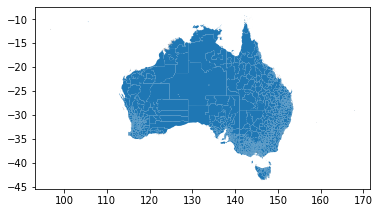

In [23]:
sf.plot()

In [24]:
gdf = gpd.GeoDataFrame(postcode_join_sf)

In [25]:
gdf.geometry.name

'geometry'

Finally draw tha plot ting

In [26]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

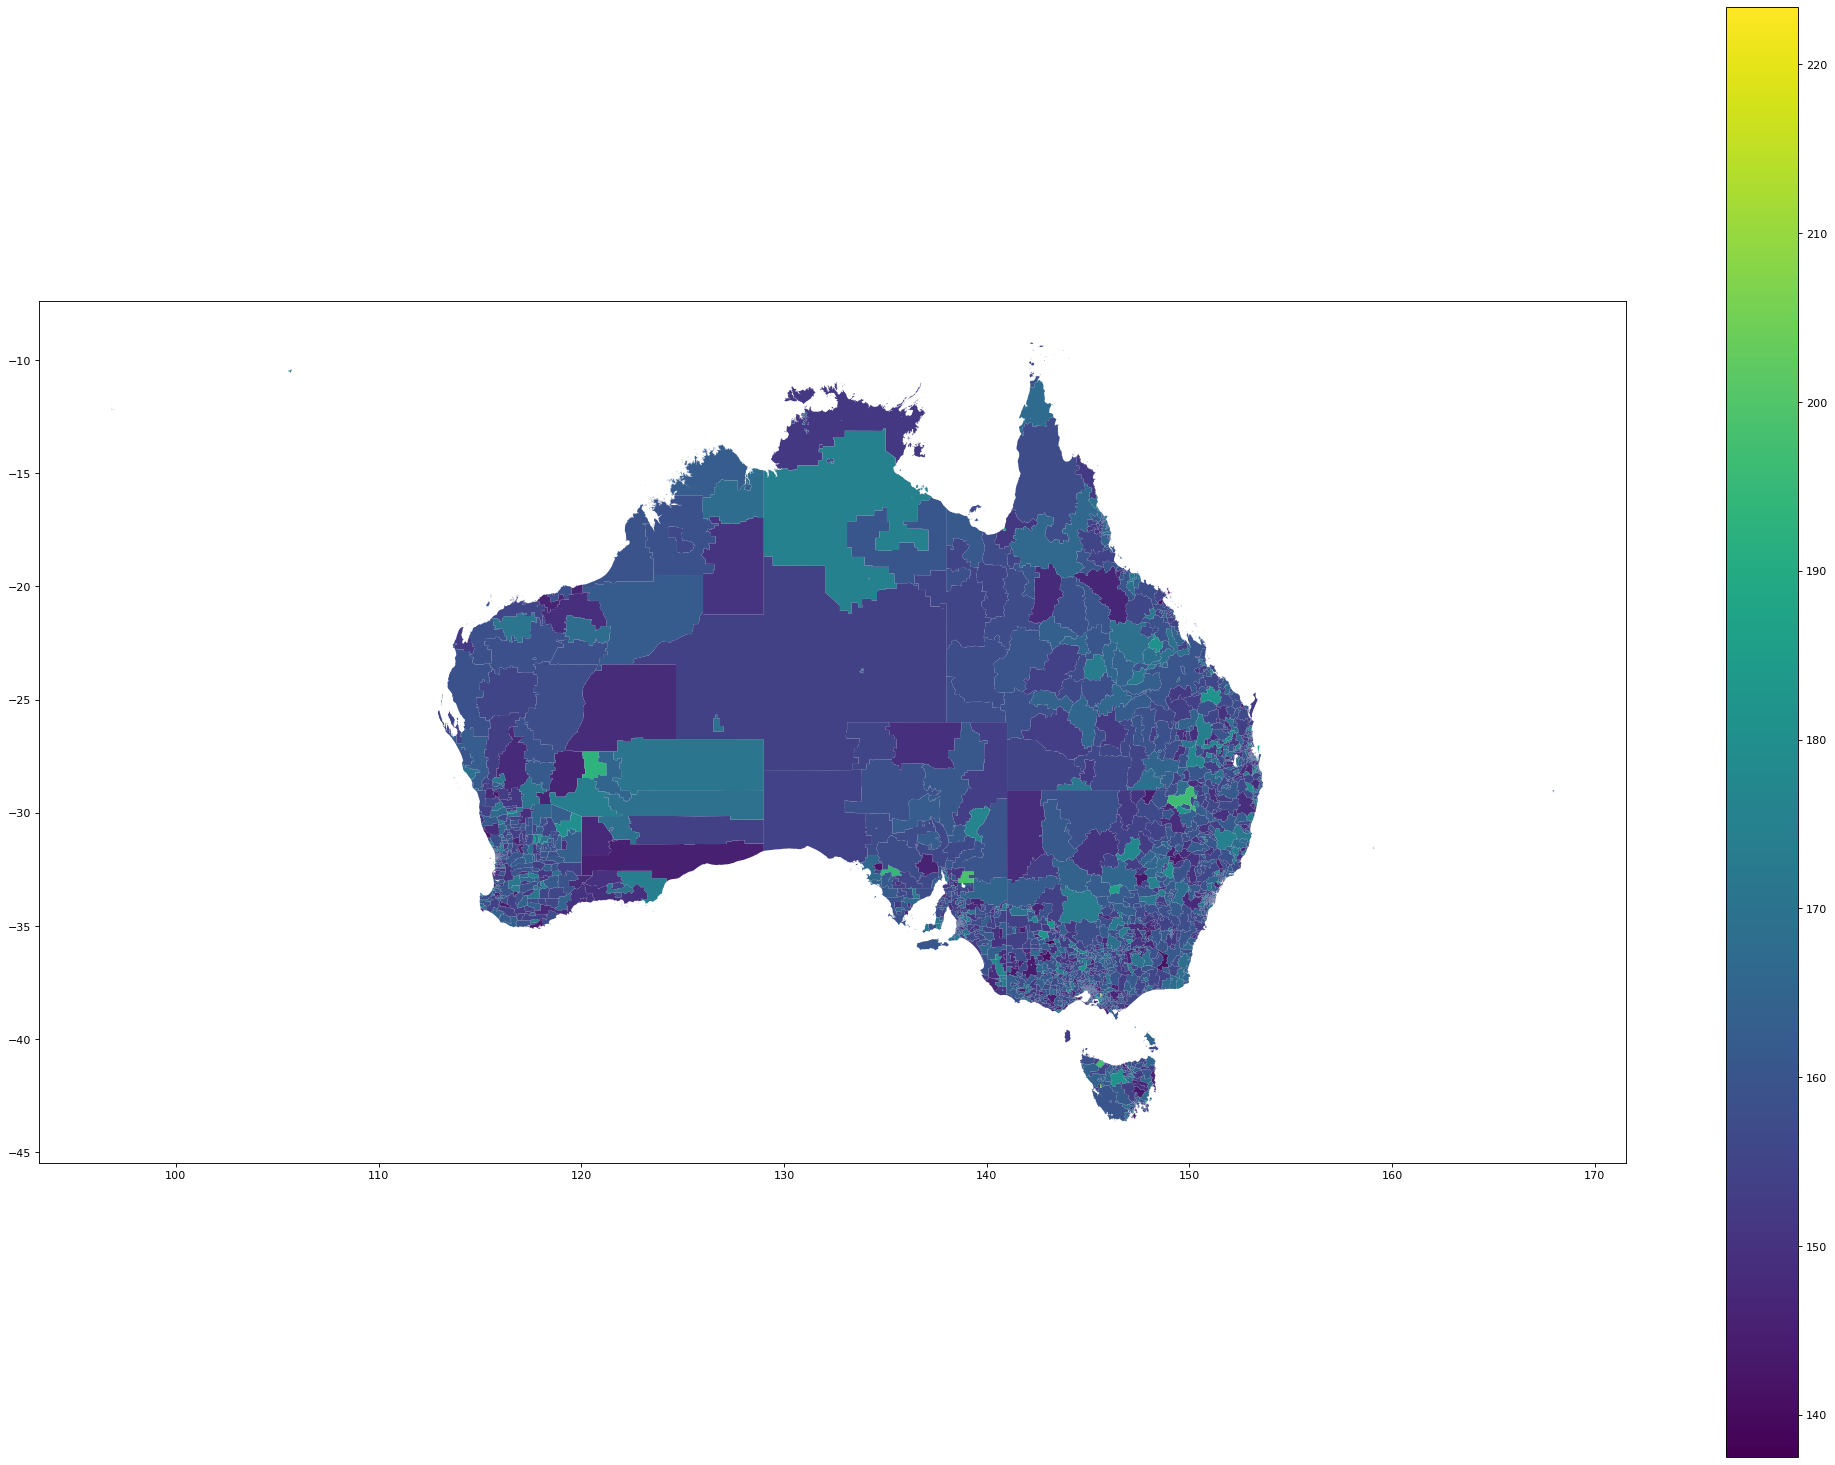

In [30]:
# plot the avg dollar values by postcode
fig, ax2 = plt.subplots(1, figsize=(32,24), dpi=80)

# align legend with plot
#divider = make_axes_locatable(ax2)
#cax = divider.append_axes("right", size="5%", pad=0.1)

# plot
gdf.plot(column=('avg(dollar_value)'),
         legend=True,
         #legend_kwds={'label' : 'Average Dollar Value by Postcode',
         #               'orientation' : 'horizontal'},
         ax=ax2,
        missing_kwds= dict(color = "red",) )#,
         #cax=cax)

plt.show()

#gdf.plot(column=('avg(dollar_value)'),legend=True, figsize=(32,24))